In [1]:
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col, isnan, when, count
import pyspark.sql.functions as Function
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
import seaborn as sns

# Adım 1: Verilerin Yüklenmesi

In [2]:
spark = SparkSession \
.builder \
.appName("Tubitak Odev 4") \
.getOrCreate()

In [3]:
csv = spark.read.csv(r"D:\YZUP-Notlarim\YZUP-Uzmanlık-Egitim\Tubitak-VeriYogunUygulamalar\Tubitak Spark Proje\data\housing.csv", inferSchema=True, header=True)

# Adım 2: Verilerin Çeşitli Spark Fonksiyonları Kullanılarak İncelenmesi

In [4]:
csv.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

### Dataframe'in sütunlarının ne türden değerler olduğunu aşağıdaki gibi görebiliyoruz.

In [5]:
csv.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



### Tek string değer ocean_proximity olduğundan dolayı bu değerimize göre gruplayıp bu değerden verilerimizde kaç adet olduğu bilgisini bastırmak istedim

<Axes: xlabel='ocean_proximity'>

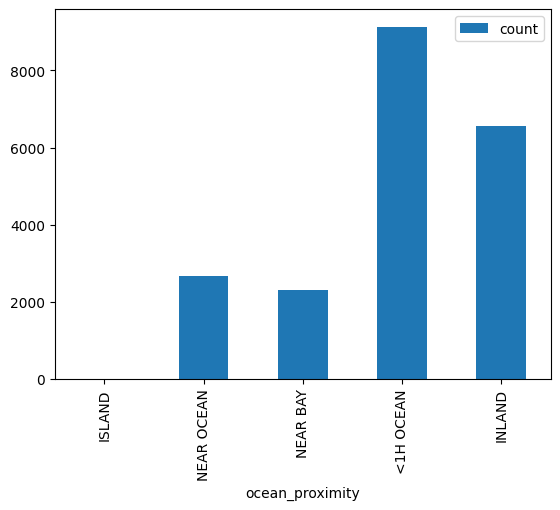

In [6]:
ocean_prox = csv.groupBy("ocean_proximity").count()
ocean_prox.toPandas().plot.bar(x="ocean_proximity")

### Sütunlarım hakkında matematiksel bilgiler almak istiyorum

In [7]:
(csv.describe().select(
                    "summary",
                    Function.round("longitude",2).alias("longitude"),
                    Function.round("latitude",2).alias("latitude"),
                    Function.round("housing_median_age", 2).alias("housing_median_age"),
                    Function.round("total_rooms", 2).alias("total_rooms"),
                    Function.round("total_bedrooms", 2).alias("total_bedrooms"),
                    Function.round("population", 2).alias("population"),
                    Function.round("households", 2).alias("households"),
                    Function.round("median_income", 2).alias("median_income"),
                    Function.round("median_house_value", 2).alias("median_house_value"))
                    .show())

+-------+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|summary|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+-------+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  count|  20640.0| 20640.0|           20640.0|    20640.0|       20433.0|   20640.0|   20640.0|      20640.0|           20640.0|
|   mean|  -119.57|   35.63|             28.64|    2635.76|        537.87|   1425.48|    499.54|         3.87|         206855.82|
| stddev|      2.0|    2.14|             12.59|    2181.62|        421.39|   1132.46|    382.33|          1.9|         115395.62|
|    min|  -124.35|   32.54|               1.0|        2.0|           1.0|       3.0|       1.0|          0.5|           14999.0|
|    max|  -114.31|   41.95|              52.0|    39320.0|        6445.0|   35682.0|    6

### Sütunlarımdaki boş değerlerimin sayısını görüntülemek istiyorum ve görüldüğü üzere sadece total_bedrooms alanında boş değerlerim bulunmakta

In [8]:
for column in csv.columns:
    print(column, csv.select(count(when(col(column).isNull() | isnan(column), column)).alias(column)).collect()[0][0])

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


### Ev değerlerinin medyan cinsinden yoğunluğu 500000'de birden artıyor

C:\Users\dagde\AppData\Local\Temp\ipykernel_30292\213011547.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(csv.select("median_house_value").toPandas())


<Axes: ylabel='Density'>

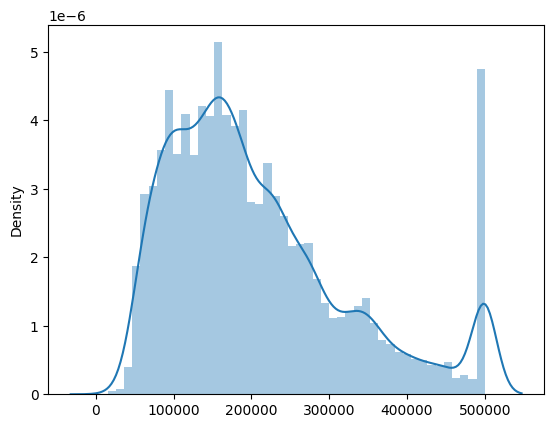

In [9]:
sns.distplot(csv.select("median_house_value").toPandas())

# Adım 3: Özniteliklerin seçimi ve verilerin makine öğrenmesi için hazırlanması


### total bedroom's sutunumuzda 207 adet boş değerimiz bulunmakta bu boş değerleri ortalama ile dolduracağım

In [10]:
mean = csv.select(Function.mean('total_bedrooms')).collect()[0][0]
csv = csv.na.fill({'total_bedrooms': mean})

In [11]:
for column in csv.columns:
    print(column, csv.select(count(when(col(column).isNull() | isnan(column), column)).alias(column)).collect()[0][0])

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


### ocean_proximity'deki değerlerim string olduğu için bu değerlerimi OneHotEncoder ile sayısal verilere dönüştüreceğim

In [12]:
str_indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_index")
csv = str_indexer.fit(csv).transform(csv)

encoder = OneHotEncoder(inputCol="ocean_proximity_index", outputCol="ocean_proximity_encoded", dropLast=False)
csv = encoder.fit(csv).transform(csv)

csv = csv.drop("ocean_proximity_index")
csv.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|ocean_proximity_encoded|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|          (5,[3],[1.0])|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|          (5,[3],[1.0])|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|          (5,[3],[1.0])|
|  -122.25|   37.85|        

In [13]:
from pyspark.ml.functions import vector_to_array
csv = csv.select("*", vector_to_array("ocean_proximity_encoded").alias("ocean_prox_onehot"))
csv.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----------------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|ocean_proximity_encoded|   ocean_prox_onehot|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----------------------+--------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|          (5,[3],[1.0])|[0.0, 0.0, 0.0, 1...|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|          (5,[3],[1.0])|[0.0, 0.0, 0.0, 1...|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177

In [14]:
num_categories = len(csv.first()['ocean_prox_onehot'])
cols_expanded = [(Function.col('ocean_prox_onehot')[i]) for i in range(num_categories)]
csv = csv.select("longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value",*cols_expanded)
csv.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_prox_onehot[0]|ocean_prox_onehot[1]|ocean_prox_onehot[2]|ocean_prox_onehot[3]|ocean_prox_onehot[4]|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|                 0.0|                 0.0|                 0.0|                 1.0|                 0.0|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|    

### Özniteliklerin birbirleri ile korelasyonuna bakalım ve bu korelasyon değerlerinin 1'e ve -1'e yakınsayanlarını silelim. Çünkü korelasyonun kesin bir değeri olarak -1 veya 1'e yakınsaması, tek başına bir özniteliğin diğerine tamamen bağımlı olduğu anlamına gelir ki bu durum istenmeyen bir durumdur.

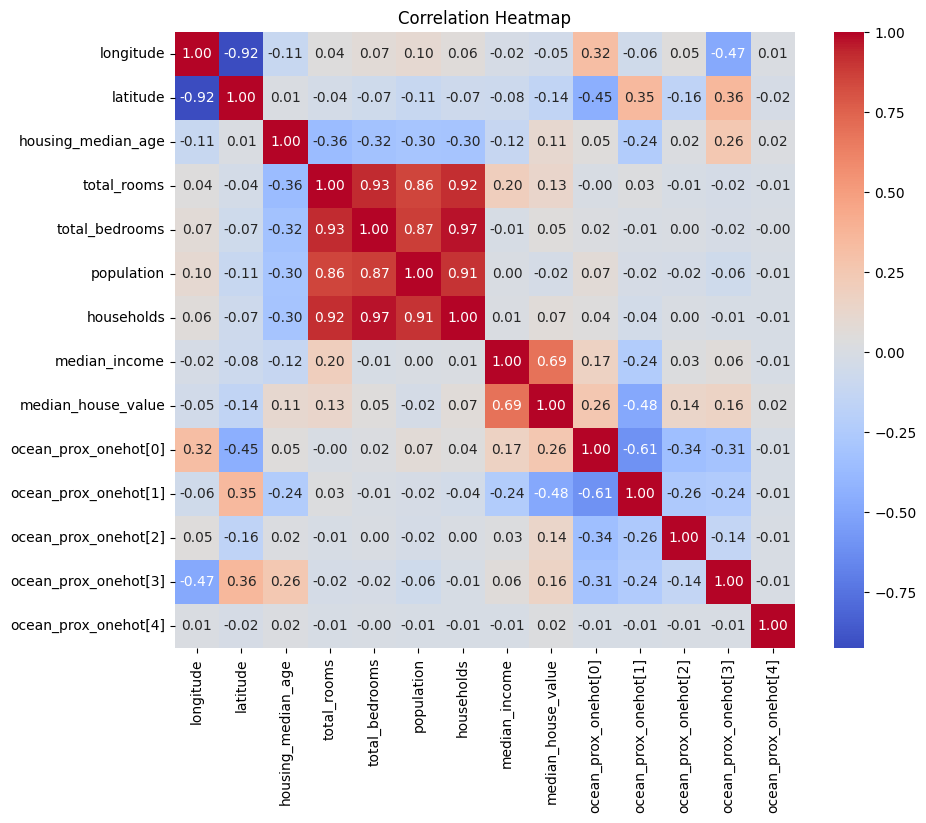

In [15]:
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt

vectorAssembler = VectorAssembler(inputCols=csv.columns, outputCol="features")
vector_df = vectorAssembler.transform(csv).select("features")

matrix = Correlation.corr(vector_df, "features")
correlation_matrix = matrix.collect()[0][0].toArray()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=csv.columns, yticklabels=csv.columns)
plt.title('Correlation Heatmap')
plt.show()

### Yukarıda gözüktüğü üzere birbirleri ile yüksek korelasyon içeren değerler şu şekildedir (longitude, latitude) (total_rooms, total_bedrooms, population, households) bu değerlerden parantezlerde bir tane bırakmak üzere diğerlerini sileceğim

In [16]:
dropped_cols = ["latitude", "total_bedrooms", "population", "households"]
csv = csv.drop(*dropped_cols) \
   

Tekrardan özniteliklerin korelasyonuna bakacağız

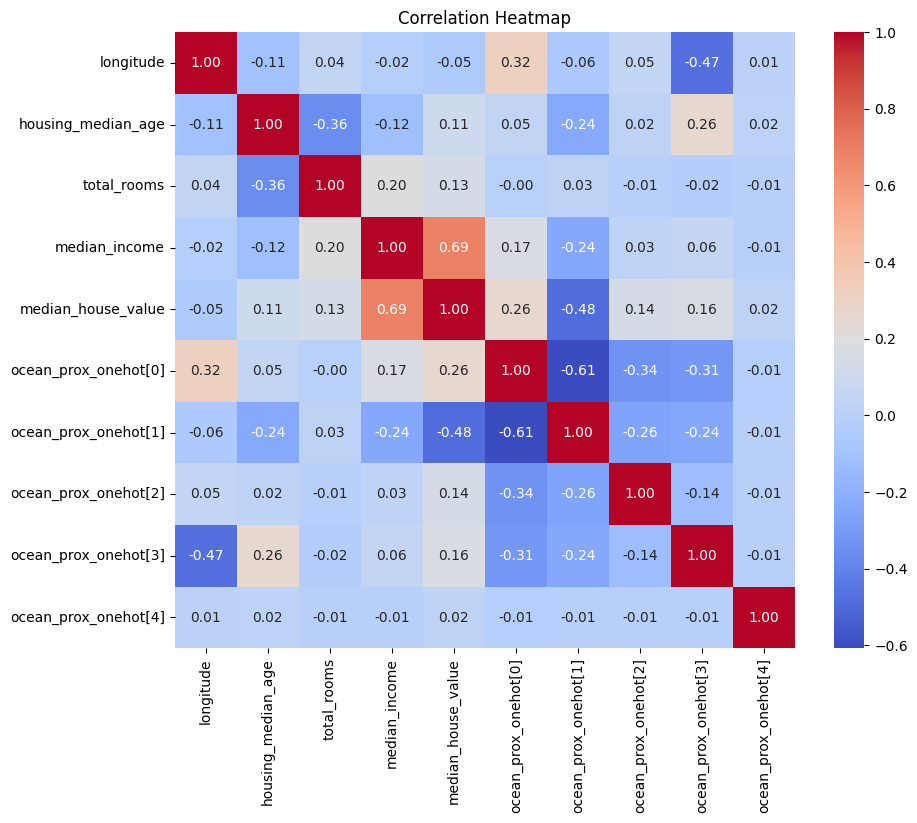

In [17]:
vectorAssembler = VectorAssembler(inputCols=csv.columns, outputCol="features")
vector_df = vectorAssembler.transform(csv).select("features")

matrix = Correlation.corr(vector_df, "features")
correlation_matrix = matrix.collect()[0][0].toArray()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=csv.columns, yticklabels=csv.columns)
plt.title('Correlation Heatmap')
plt.show()

### Verileri makine öğrenimi için train ve test olmak üzere böleceğiz.

In [18]:
data = csv.select("longitude", "housing_median_age", "total_rooms","median_income", "median_house_value", "ocean_prox_onehot[0]","ocean_prox_onehot[1]","ocean_prox_onehot[2]", "ocean_prox_onehot[3]", "ocean_prox_onehot[4]")
splits = data.randomSplit([0.7, 0.3])
train = splits[0]
test = splits[1]

In [19]:
train_rows_count = train.count()
test_rows_count = test.count()

In [20]:
print("Training Rows:", train_rows_count, " Testing Rows:", test_rows_count)

Training Rows: 14487  Testing Rows: 6153


### Eğitim Verilerinin Hazırlanması

In [21]:
assembler = VectorAssembler(inputCols=["longitude", "housing_median_age", "total_rooms","median_income", "ocean_prox_onehot[0]","ocean_prox_onehot[1]","ocean_prox_onehot[2]", "ocean_prox_onehot[3]", "ocean_prox_onehot[4]"], outputCol="features")
training = assembler.transform(train).select(col("features"),col("median_house_value").alias("label"))
training.show()

+--------------------+--------+
|            features|   label|
+--------------------+--------+
|[-124.35,52.0,182...| 94600.0|
|[-124.3,17.0,2677...|103600.0|
|[-124.3,19.0,2672...| 85800.0|
|[-124.26,52.0,221...|111400.0|
|[-124.25,32.0,143...| 76100.0|
|[-124.23,52.0,111...| 50800.0|
|[-124.23,52.0,269...|106700.0|
|[-124.22,28.0,300...| 78300.0|
|[-124.21,17.0,346...| 68400.0|
|[-124.21,20.0,381...| 66900.0|
|[-124.21,32.0,121...| 58100.0|
|[-124.19,15.0,314...| 74600.0|
|[-124.19,30.0,297...| 69000.0|
|[-124.18,33.0,107...| 72200.0|
|[-124.18,34.0,159...| 67000.0|
|[-124.18,37.0,145...| 70200.0|
|[-124.17,13.0,217...|116100.0|
|[-124.17,16.0,273...|109400.0|
|[-124.17,17.0,202...|128900.0|
|[-124.17,20.0,267...|105900.0|
+--------------------+--------+
only showing top 20 rows



### Test Verilerinin Hazırlanması

In [22]:
testing = assembler.transform(test).select(col("features"),col("median_house_value").alias("label"))
testing.show()

+--------------------+--------+
|            features|   label|
+--------------------+--------+
|[-124.27,36.0,234...| 79000.0|
|[-124.23,11.0,315...| 73200.0|
|[-124.19,21.0,569...| 90100.0|
|[-124.19,37.0,137...| 70000.0|
|[-124.18,35.0,952...|107000.0|
|[-124.18,39.0,183...| 70500.0|
|[-124.18,40.0,139...| 64600.0|
|[-124.17,26.0,177...| 82800.0|
|[-124.17,30.0,189...| 81300.0|
|[-124.17,39.0,160...| 68300.0|
|[-124.17,52.0,160...| 75500.0|
|[-124.16,35.0,214...| 85600.0|
|[-124.16,46.0,197...| 81800.0|
|[-124.16,52.0,170...| 74100.0|
|[-124.16,52.0,216...| 74700.0|
|[-124.15,24.0,285...|100600.0|
|[-124.15,33.0,223...| 57500.0|
|[-124.15,39.0,118...| 79600.0|
|[-124.15,41.0,212...|104200.0|
|[-124.15,47.0,148...| 74100.0|
+--------------------+--------+
only showing top 20 rows



# Adım 4: PySpark ile makine öğrenmesi modelinin oluşturulması

In [23]:
lr = LinearRegression(labelCol="label", featuresCol="features", maxIter=10, regParam=0.3)
model = lr.fit(training)
print("Model finished")

Model finished


# Adım 5: Geliştirilen modelin performansının ölçümü

1. Mae modelin gerçek değerleri ile tahmin edilen değerler arasındaki mutlak farkın ortalamasıdır ve 0-1 arasındadır 0 a ne kadar yakınsa model o kadar iyidir.
2. R2 bağımlı değişkenin varyasyonunun bağımsız değişkenler tarafından açıklanma yüzdesini ölçer ve 0-1 arasındadır 1 e ne kadar yakınsa model o kadar iyidir

In [24]:
pred_results_from_train = model.evaluate(training)
print("The MAE for the model is: %2f"% pred_results_from_train.meanAbsoluteError)
print("The r2 for the model is: %2f"% pred_results_from_train.r2)

The MAE for the model is: 52896.791404
The r2 for the model is: 0.602790


In [25]:
pred_results_from_test = model.evaluate(testing)
print("The MAE for the model is: %2f"% pred_results_from_test.meanAbsoluteError)
print("The r2 for the model is: %2f"% pred_results_from_test.r2)

The MAE for the model is: 53113.589638
The r2 for the model is: 0.598619


In [26]:
from pyspark.sql.functions import monotonically_increasing_id

prediction = model.transform(testing)
predicted = prediction.select("features", "prediction", "label")
predicted = predicted.withColumn("id",monotonically_increasing_id())

<Axes: xlabel='label', ylabel='prediction'>

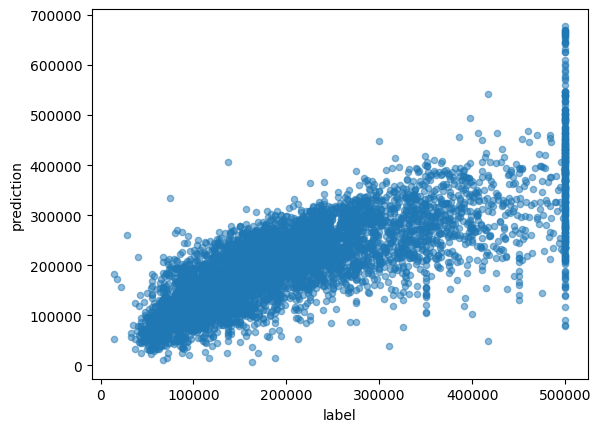

In [27]:
df_predicted = predicted.toPandas()
df_predicted.plot.scatter(x='label', y='prediction', alpha = 0.5)